In [40]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
import time
import pandas as pd

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    0.5  |      +ve      |        


 /Users/gilikarni/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


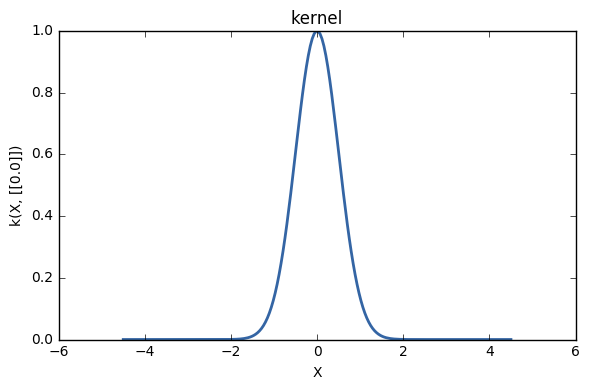

In [41]:
d = 1 # input dimension
var = 1. # variance
theta = .5 #lengthscale

k = GPy.kern.RBF(input_dim=d, variance=var, lengthscale=theta)

print k
k.plot()
plt.title('kernel')
plt.show()

In [42]:
X = np.linspace(0.,1.,500) # 500 points evenly spaced over [0,1]
X = X[:,None] # reshape X to make it n*D

mu = np.zeros((500)) # vector of the means
C = k.K(X,X) # covariance matrix

print X.shape
print mu.shape
print C.shape

(500, 1)
(500,)
(500, 500)


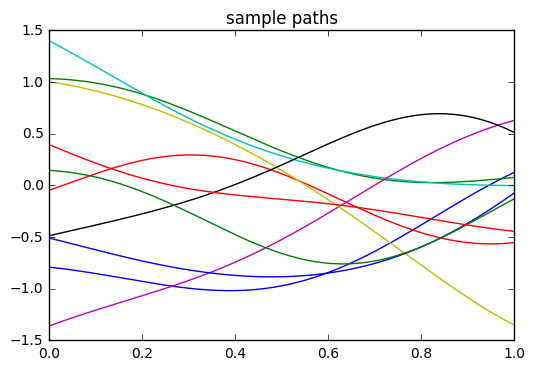

In [43]:
# Generate 10 sample path with mean mu and covariance C
Z = np.random.multivariate_normal(mu,C,10)

for i in range(10):
    plt.plot(X[:],Z[i,:])

plt.title('sample paths')
plt.show()


In [44]:
n=50
X = np.random.uniform(0., 5., (n, ))
Y = np.sin(X) + np.sin(2 * X) 
noise = np.random.normal(0,1,n)*0.05


Y=Y+noise
Y= Y[:,None]
X= X[:,None]

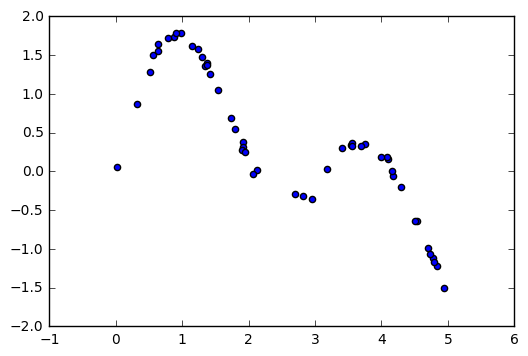

In [45]:
plt.scatter(X,Y)
plt.show()

In [46]:
m = GPy.models.GPRegression(X,Y,k)

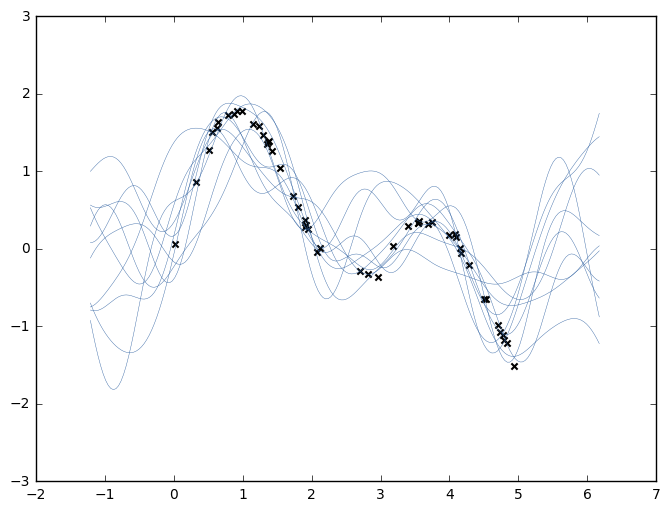

In [47]:
fig = plt.figure(figsize=(8, 6))
fig.gridspec = plt.GridSpec(1, 1)
m.plot_data(figure=fig)
m.plot_samples(samples=10, figure=fig)
plt.show()

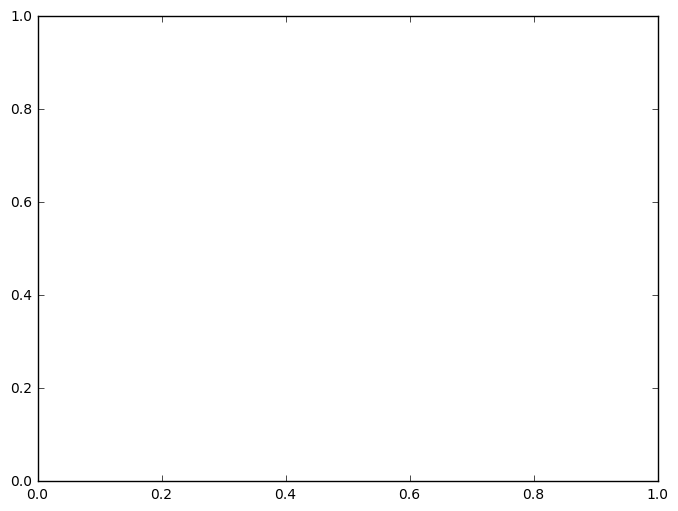

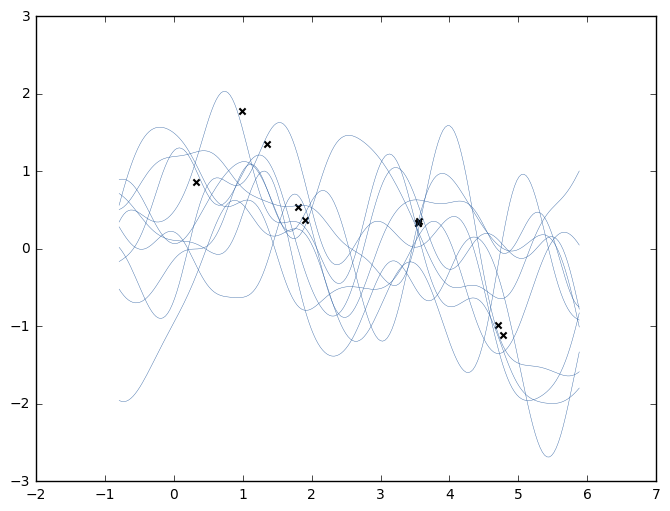

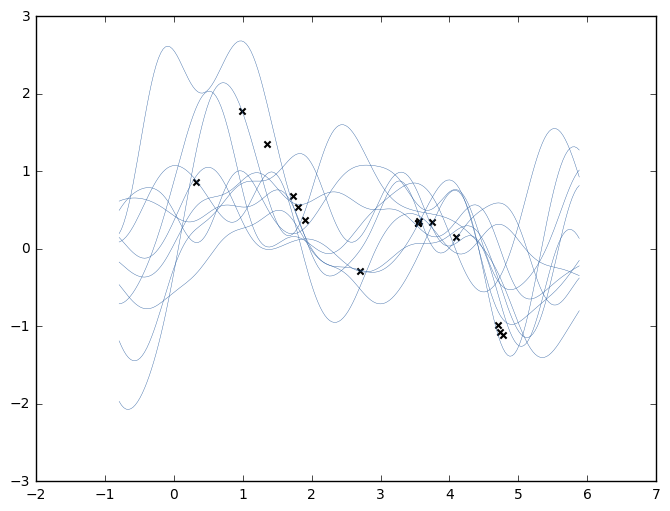

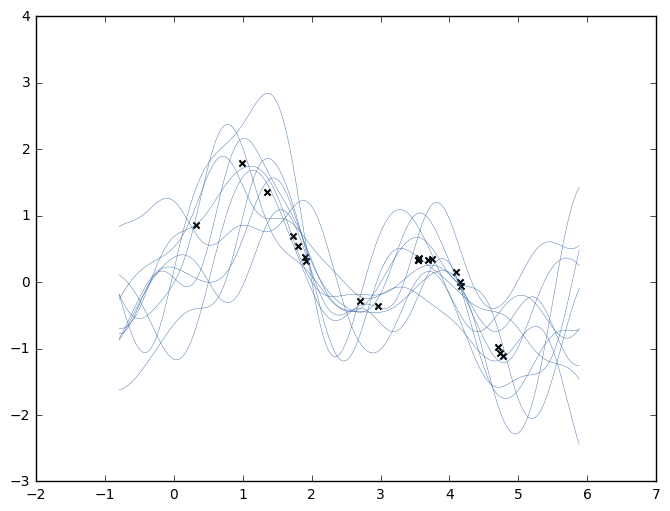

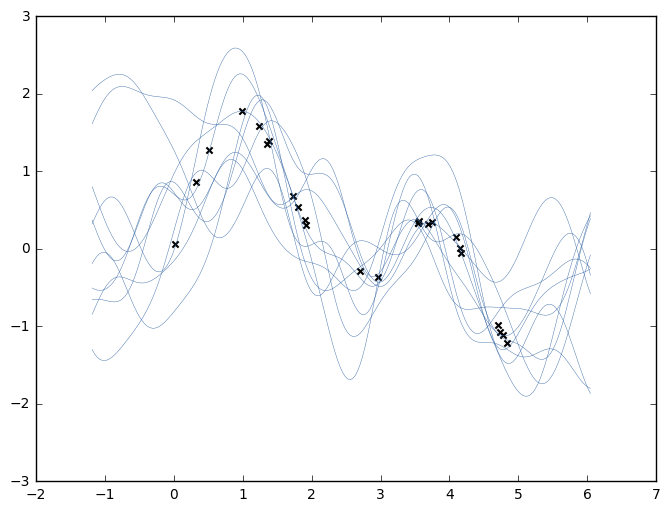

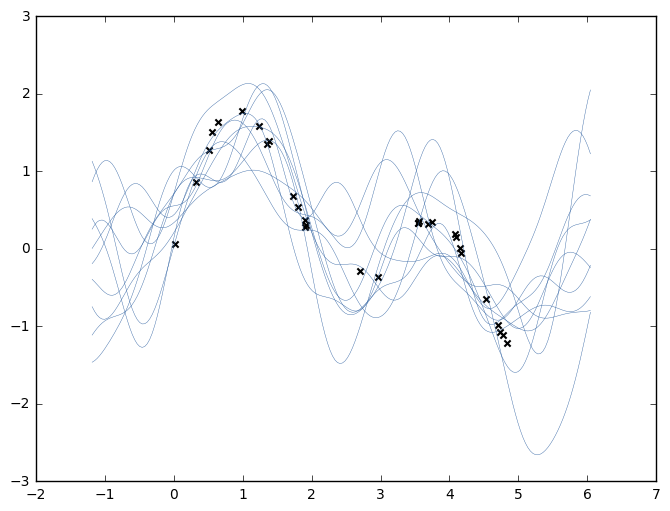

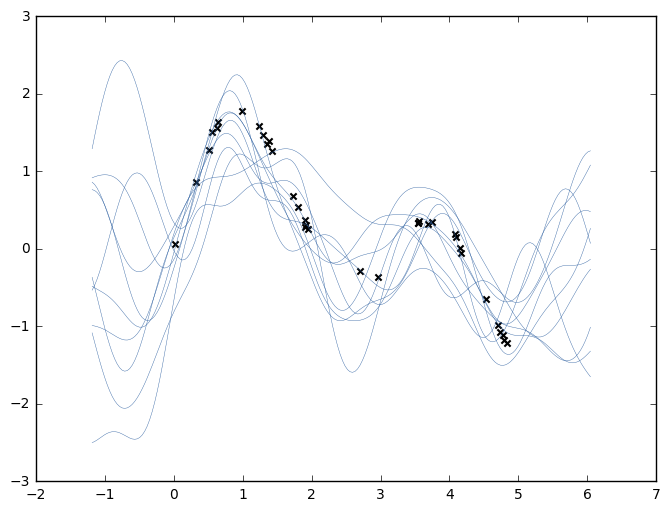

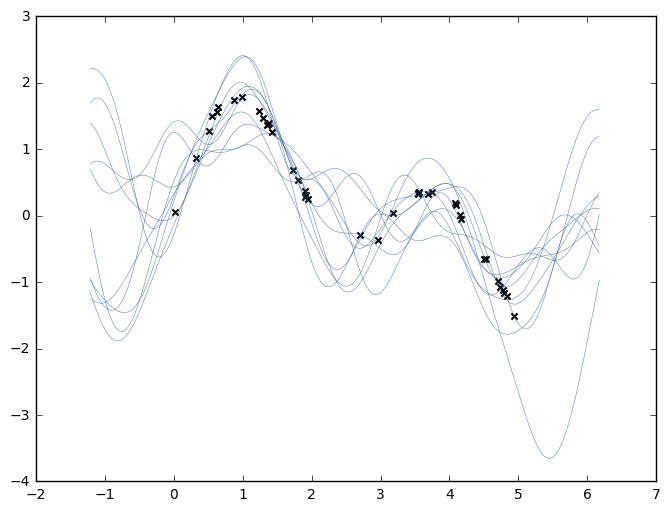

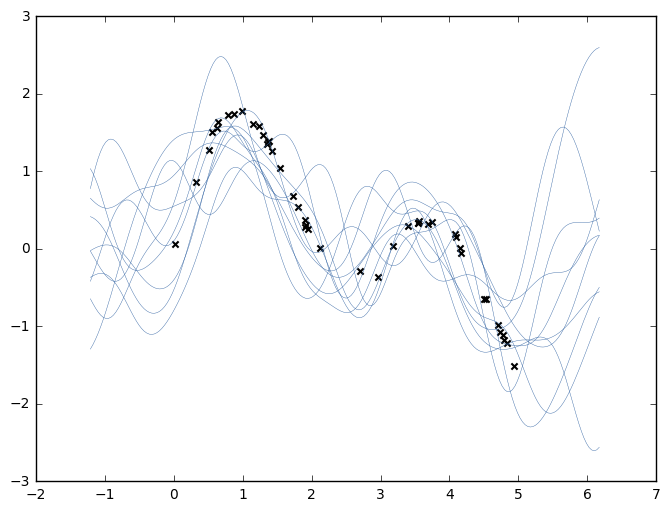

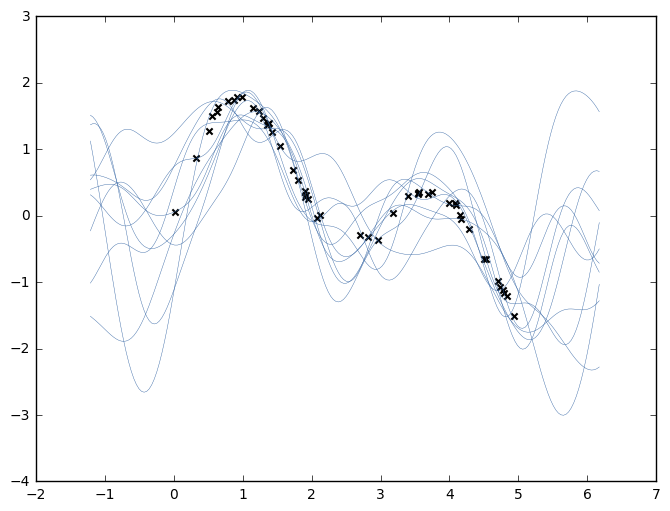

In [60]:
for i in range(10, len(X) + 1, 5):
    time.sleep(1)
    m.set_XY(X[:i], Y[:i])
    fig = plt.figure(figsize=(8, 6))
    fig.gridspec = plt.GridSpec(1, 1)
    m.plot_data(figure=fig)
    m.plot_samples(samples=10, figure=fig)

    plt.show()


In [10]:
Xp = np.linspace(0.1,0.8,8)[:,None]
mu, C = m.predict(Xp)


Before optimizing:


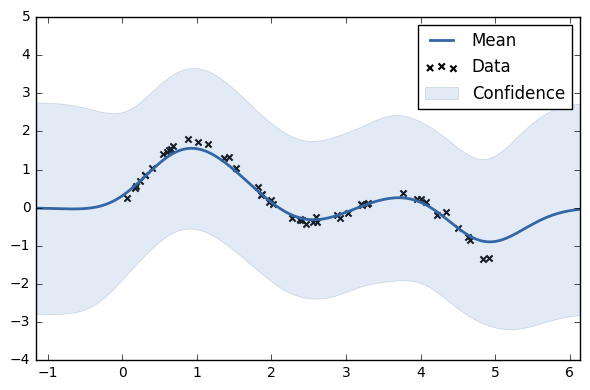

After optimizing:


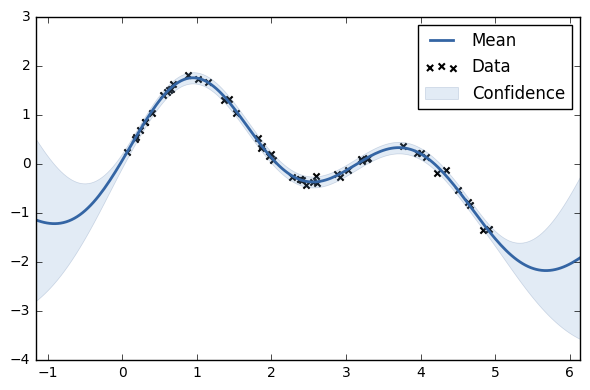

In [11]:
print 'Before optimizing:'
m.plot()
plt.show()
print 'After optimizing:'
m.optimize()
m.plot()
plt.show()

from katbailey

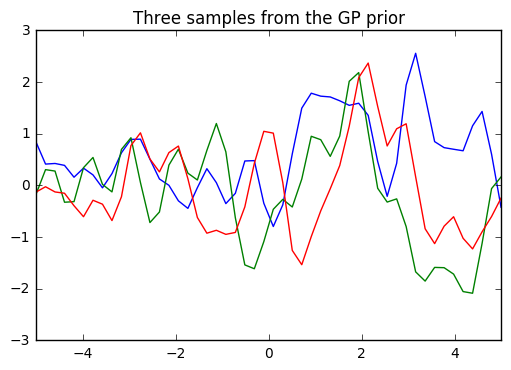

In [12]:
# Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 0.1
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the
# covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3)))

# Now let's plot the 3 sampled functions.
plt.plot(Xtest, f_prior)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP prior')
plt.show()

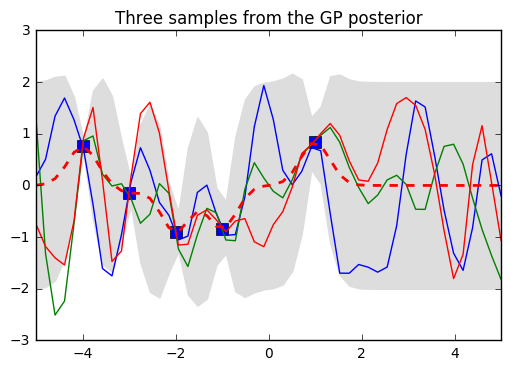

In [13]:
# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

plt.plot(Xtrain, ytrain, 'bs', ms=8)
plt.plot(Xtest, f_post)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP posterior')
plt.show()

## co2

In [12]:
co2 = pd.read_csv('data.csv', delim_whitespace=True)


In [14]:
co2.head()

,year,month,dec_date,mean,interpolated,trend,#days
0,1958,3,1958.208,315.71,315.71,314.62,-1
1,1958,4,1958.292,317.45,317.45,315.29,-1
2,1958,5,1958.375,317.50,317.50,314.71,-1
3,1958,6,1958.458,-99.99,317.10,314.85,-1
4,1958,7,1958.542,315.86,315.86,314.98,-1


In [15]:
X_C=co2['dec_date']
Y_C=co2['interpolated']

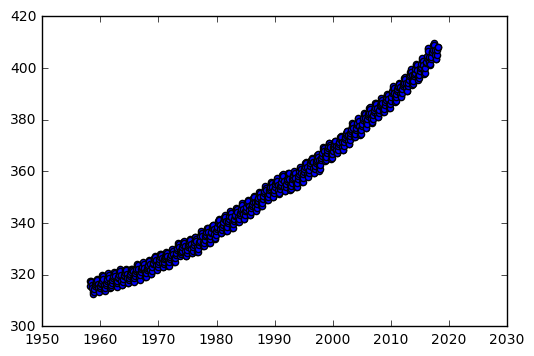

In [17]:
plt.scatter(X_C,Y_C)
plt.show()

In [25]:
k1 = GPy.kern.RBF(input_dim=1, lengthscale=67.0)  # long term smooth rising trend 
k2 = GPy.kern.RBF(input_dim=1, lengthscale=90.0) \
    * GPy.kern.StdPeriodic(input_dim=1, lengthscale=1.3, period=1.0)  # seasonal component
k3 = GPy.kern.RatQuad(input_dim=1, lengthscale=1.2, power=0.78) # medium term irregularity
k4 = GPy.kern.RBF(input_dim=1, lengthscale=0.134) \
    + GPy.kern.White(input_dim=1, variance=0.19**2)  # noise terms
    
kernel_gpml = k1 + k2 + k3 + k4

In [20]:

k_C = GPy.kern.PeriodicExponential(input_dim=1, lengthscale=1.44, period=1)


In [26]:
m_c = GPy.models.GPRegression(X_C[:,None],Y_C[:,None],kernel_gpml)

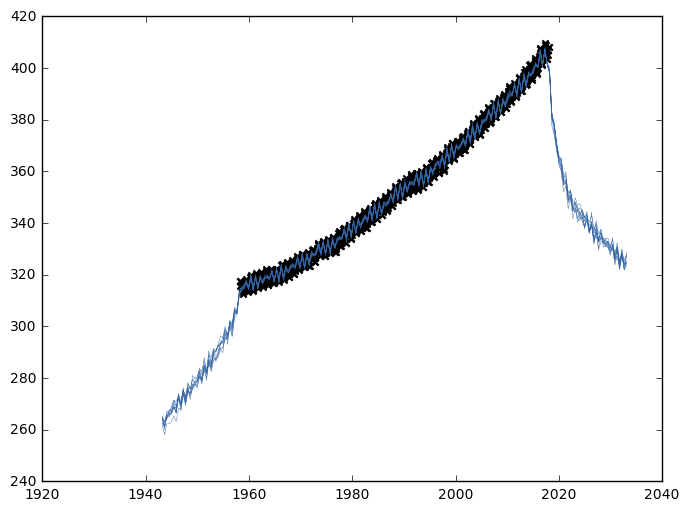

In [35]:
fig = plt.figure(figsize=(8, 6))
fig.gridspec = plt.GridSpec(1, 1)
m_c.plot_data(figure=fig)
m_c.plot_samples(samples=10, figure=fig)

plt.show()

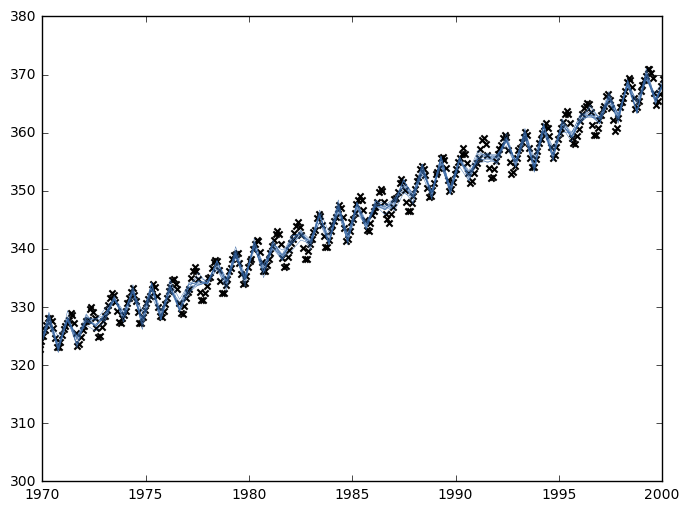

In [34]:
fig = plt.figure(figsize=(8, 6))
fig.gridspec = plt.GridSpec(1, 1)
m_c.plot_data(figure=fig)
m_c.plot_samples(samples=10, figure=fig)

plt.ylim(300,380)
plt.xlim(1970,2000)
plt.show()

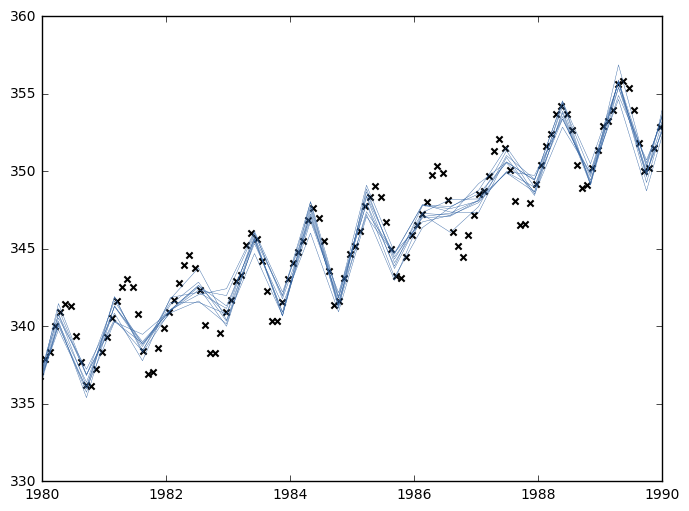

In [38]:
fig = plt.figure(figsize=(8, 6))
fig.gridspec = plt.GridSpec(1, 1)
m_c.plot_data(figure=fig)
m_c.plot_samples(samples=10, figure=fig)

plt.ylim(330,360)
plt.xlim(1980,1990)
plt.show()

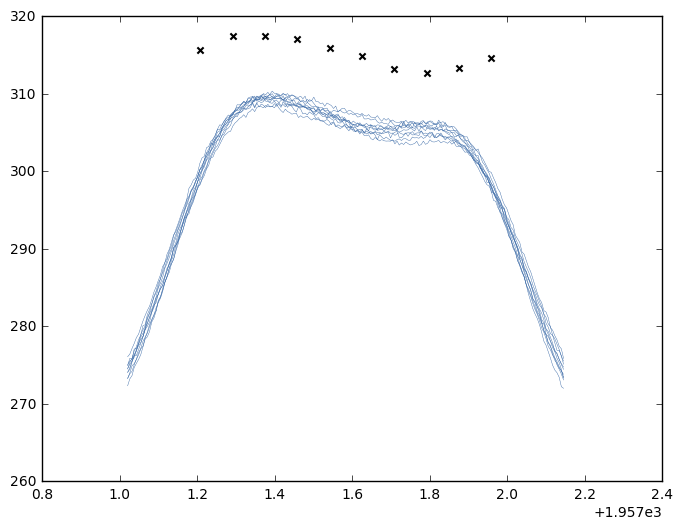

In [58]:
n = 10
m_c.set_XY(X_C[:n][:,None], Y_C[:n][:,None])

fig = plt.figure(figsize=(8, 6))
fig.gridspec = plt.GridSpec(1, 1)
m_c.plot_data(figure=fig)
m_c.plot_samples(samples=n, figure=fig)


plt.show()

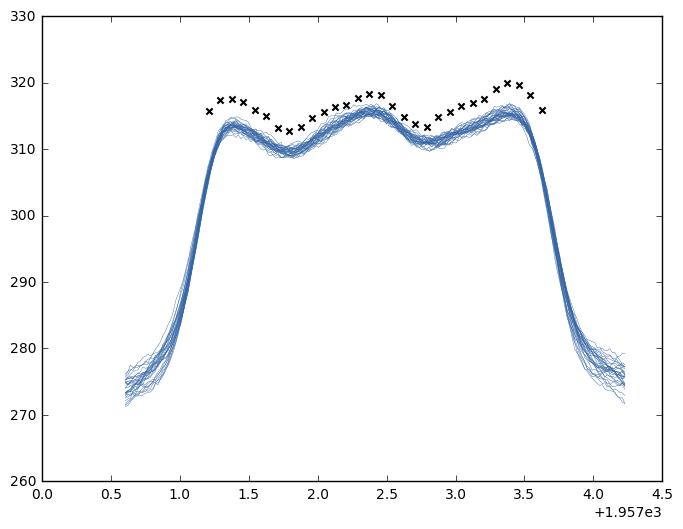

In [56]:
n = 30
m_c.set_XY(X_C[:n][:,None], Y_C[:n][:,None])

fig = plt.figure(figsize=(8, 6))
fig.gridspec = plt.GridSpec(1, 1)
m_c.plot_data(figure=fig)
m_c.plot_samples(samples=n, figure=fig)


plt.show()

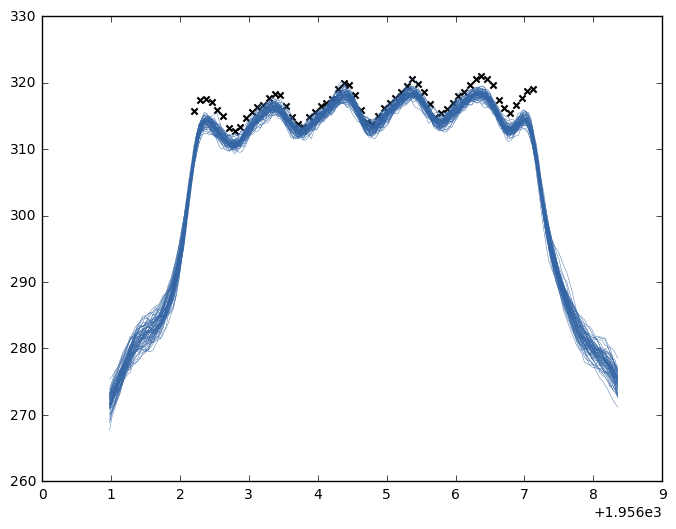

In [57]:
n = 60
m_c.set_XY(X_C[:n][:,None], Y_C[:n][:,None])

fig = plt.figure(figsize=(8, 6))
fig.gridspec = plt.GridSpec(1, 1)
m_c.plot_data(figure=fig)
m_c.plot_samples(samples=n, figure=fig)


plt.show()